# 1. Setup Mario

In [1]:
#!pip install gym_super_mario_bros==7.3.0 nes_py <- done via terminal
#

In [2]:
# Import the game
import gym
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
from gym_super_mario_bros.actions import RIGHT_ONLY
#import other
from matplotlib import pyplot as plt

In [3]:
# Setup game
#env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = gym_super_mario_bros.make('SuperMarioBros-v3', apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)

C:\Users\ivanc\anaconda3\envs\mario\Lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [4]:
# Create a flag - restart or not
done = True
# Loop through each frame in the game
for step in range(10000): #100000
    # Start the game to begin with 
    if done: 
        # Start the gamee
        env.reset()
    # Do random actions
    #state, reward, done, info = env.step(env.action_space.sample())
    state, reward, done, truncated, info = env.step(env.action_space.sample())
    # Show the game on the screen
    env.render()
# Close the game
env.close()

C:\Users\ivanc\anaconda3\envs\mario\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\ivanc\anaconda3\envs\mario\Lib\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(
C:\Users\ivanc\anaconda3\envs\mario\Lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


# 2. Preprocess Environment

In [5]:
# Install pytorch
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
#pip install torch

In [6]:
# Install stable baselines for RL stuff
#!pip install stable-baselines3[extra] <- done via terminal

In [7]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

In [8]:
# 1. Create the base environment
#env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = gym_super_mario_bros.make('SuperMarioBros-v3', apply_api_compatibility=True, render_mode="human")
# 2. Simplify the controls 
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

C:\Users\ivanc\anaconda3\envs\mario\Lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
C:\Users\ivanc\anaconda3\envs\mario\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [9]:
JoypadSpace.reset = lambda self, **kwargs: self.env.reset(**kwargs) #gym==0.26.2 (https://stackoverflow.com/a/76562664)
state = env.reset()

In [10]:
#state, reward, done, truncated, info = env.step([5])
state, reward, done, info = env.step([5])

C:\Users\ivanc\anaconda3\envs\mario\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


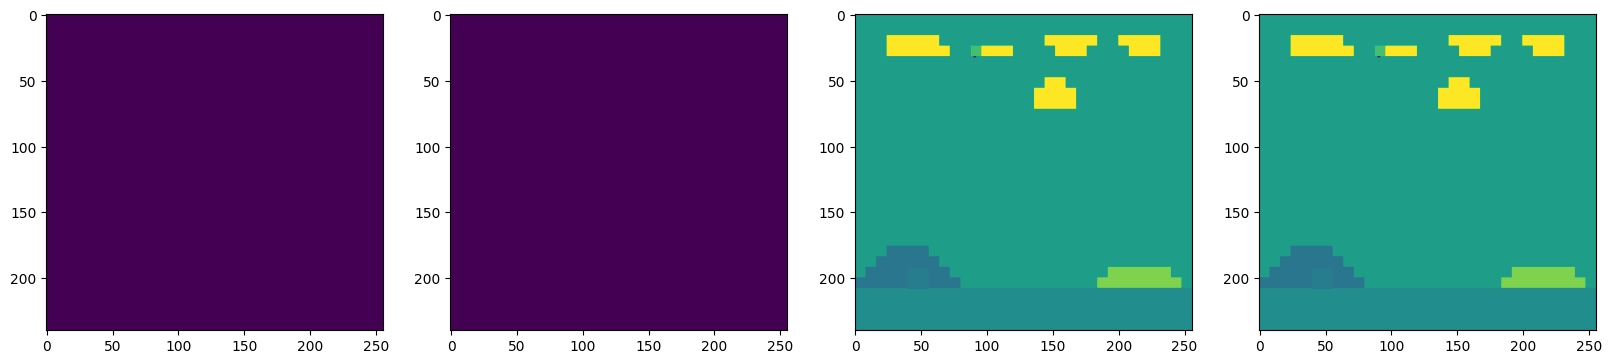

In [11]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

# 3. Train the RL Model

In [12]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [13]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [14]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [15]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [16]:
# This is the AI model started
#model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, n_steps=512)
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.0001, n_steps=512) 

Using cpu device
Wrapping the env in a VecTransposeImage.


In [17]:
# Train the AI model, this is where the AI model starts to learn
#model.learn(total_timesteps=1000000, callback=callback)
model.learn(total_timesteps=1000000, callback=callback)

Logging to ./logs/PPO_2


C:\Users\ivanc\anaconda3\envs\mario\Lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 85  |
|    iterations      | 1   |
|    time_elapsed    | 6   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 2           |
|    time_elapsed         | 39          |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.011674669 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -0.00394    |
|    learning_rate        | 0.0001      |
|    loss                 | 10.1        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00934    |
|    value_loss           | 55.6        |
-----------------------------------------
-----------------------------------------

In [18]:
model.save('thisisatestmodel')

# 4. Test it Out

In [19]:
# Load model
model = PPO.load('./train/best_model_1000000')

In [20]:
state = env.reset()

In [22]:
# Start the game 
JoypadSpace.reset = lambda self, **kwargs: self.env.reset(**kwargs) #gym==0.26.2 (https://stackoverflow.com/a/76562664)
state = env.reset()
# Loop through the game
while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

KeyboardInterrupt: 